In [1]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

In [2]:
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets.waymo.waymo_dataset_bc import WaymoDatasetBC as WaymoDataset
# from mtr.datasets.waymo.waymo_dataset import WaymoDataset

from rl_env.mtr_env import BatchMTREnv
# from tools.mtr_inference import MTRInference
from tools.mtr_lightning import MTR_Lightning
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Independent

cfg = cfg_from_yaml_file('tools/cfgs/waymo/bc+10_percent_data_atten.yaml', cfg)
dataset = WaymoDataset(cfg.DATA_CONFIG, training=True)
env = BatchMTREnv(1, dataset)


/home/zixuzhang/mambaforge/envs/waymax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total scenes before filters: 49065


In [3]:
# model = MTR_Lightning(cfg)
# model = MTR_Lightning.load_from_checkpoint('output/bc_atten_0_unfreeze/epoch=31-step=97664.ckpt')
model = MTR_Lightning.load_from_checkpoint('output/bc_atten_2_freeze/epoch=49-step=152600.ckpt')
# model = MTR_Lightning.load_from_checkpoint('output/bc_atten_0_freeze/epoch=31-step=97664.ckpt')
_ = model.cuda()


# Test with dataset

In [ ]:
output_mean = model.model.motion_decoder.output_mean
output_std = model.model.motion_decoder.output_std

In [ ]:
data = dataset[5]
data_batch = dataset.collate_batch([data])

In [ ]:
# model.train()
model.eval()
with torch.no_grad():
    loss, _, output = model.model(data_batch, True)
    center_gt_raw = output['input_dict']['center_gt'][..., :3]
    center_gt = output['input_dict']['center_gt'][...,None, :3].cuda()
    center_gt = (center_gt - output_mean) / output_std


In [ ]:

for pred_ctrls, pred_scores in output['pred_list']:
    i=-1
    print(pred_ctrls.shape)
    print(pred_ctrls[i, :, :3])
    print(pred_scores[i, :])
    # print(center_gt[i])
    # print(center_gt_raw[i])

In [ ]:

mode = model.model.motion_decoder.build_mode_distribution(pred_ctrls[...,:])
log_p = mode.log_prob(center_gt)
print(log_p)

In [ ]:
_, mode, gmm = model.model.motion_decoder.build_gmm_distribution(pred_ctrls, pred_scores)
log_p = -gmm.log_prob(center_gt.squeeze(1))
log_p

In [ ]:
mode, mix, gmm, sample = model.sample(data_batch)
print(sample)
print(center_gt_raw)

# Test in simulation

In [17]:
env.reset()

torch.Size([31600, 7])


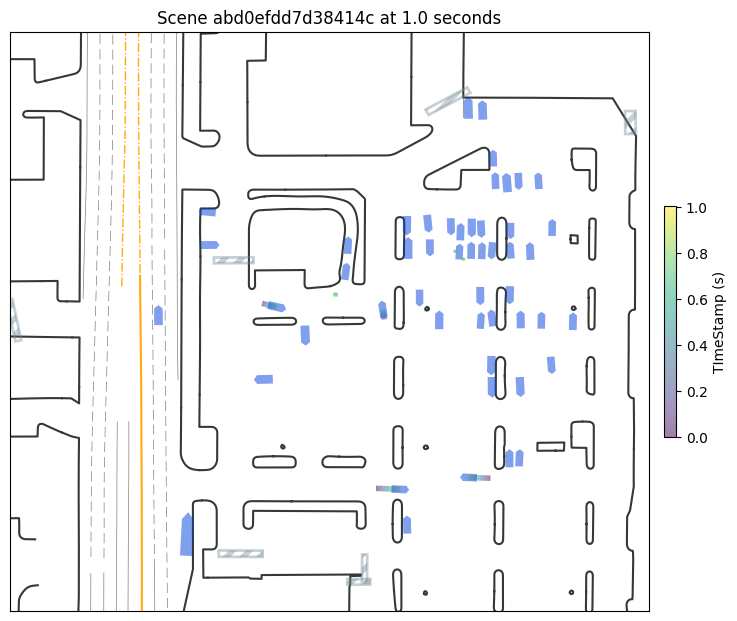

In [20]:
# Reset Time
for temp_env in env.envs_list:
    index = temp_env.index
    temp_env.reset(index)
env.visualize()
current_time_index = env.envs_list[0].current_time_index 

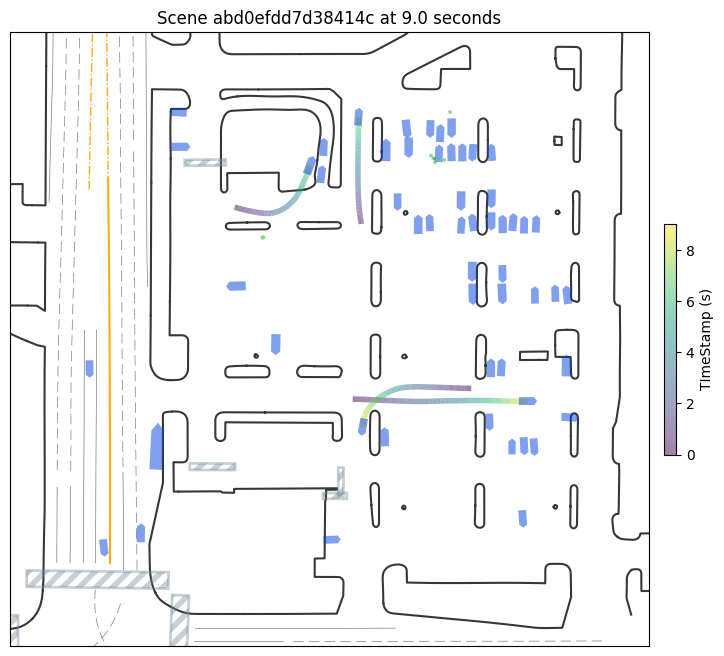

In [19]:
for _ in range(80):
    data_batch_sim = env.batch_sim_data
    action = model.sample(data_batch_sim, -1)[-1]
    _ = env.step(data_batch_sim, action)
_ = env.visualize()